In [307]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
import operator
from scipy.optimize import minimize
import math

In [308]:
def gen_dx_recursive(mu_real,sig_real,dt,N):
    N=np.int64(N)
    X = np.zeros((N))
    X[0]=0.5
    p=0.5+ 0.5*np.sin(np.linspace(0,2*math.pi,N))
    dW=np.sqrt(dt)*np.random.normal(0, 1, N)
    #e = np.zeros((N))
    scale=100
    for i in range(1,N):
        b= sig_real*X[i-1]*(1-X[i-1])
        a= mu_real*(p[i] - X[i-1])
        X[i]= X[i-1]+ a*dt+ b*dW[i-1]
    return(X*scale) 

In [309]:
def liklihood(param,data, disc):
    L=0
    X=data
    N,dt=disc;
    N=np.int64(N)
    mu,sig =param;
    for i in range(1,N):
        b= sig*X[i-1]*(1-X[i-1])
        a= mu*(0.5 - X[i-1])
        L = L  - (X[i]-X[i-1]-a*dt )**2/(2*dt*b**2) -0.5*np.log(2*math.pi*b**2*dt)
    return(-1*L)

In [310]:
def covergence_test(disc ,param_real, param_initial):
    
    N,dt=disc;
    mu_real,sig_real=param_real
    mu_initial,sig_initial=param_initial
    
    X=gen_dx_recursive(mu_real,sig_real,dt,N)
    
    args=(X,disc)
    x0=param_initial
    bnds = ((None, None), (1e-5, None))
    
    min_param=minimize(liklihood,x0,args,bounds=bnds,tol=1e-24);min_param

    error = np.divide ( abs(min_param.x - param_real),param_real )
    
    return(min_param.x, error)

In [311]:
#varying number of samples

def convergence_in_N(N_test,fix_dt,param_real_test,param_initial_test):

    err_fixeddt=np.zeros((len(N_test),2))
    result_fixeddt=np.zeros((len(N_test),2))

    for i in range(0,len(N_test)):
        disc_test=np.array([N_test[i],fix_dt])
        result_fixeddt[i,:],err_fixeddt[i,:]=covergence_test(disc_test,param_real_test,param_initial_test)
        
    return(result_fixeddt,err_fixeddt)

In [312]:
#varying number of paths

def convergence_in_L(N_test,fix_dt,param_real_test,param_initial_test,num_paths ):
    result_fixeddt= np.zeros(( num_paths ,len(N_test),2))
    err_fixeddt= np.zeros(( num_paths ,len(N_test),2))

    for i in range(0,num_paths):
        result_fixeddt[i,:,:],err_fixeddt[i,:,:]=convergence_in_N(N_test,fix_dt,param_real_test,param_initial_test)
    return(result_fixeddt, err_fixeddt)


In [313]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', label='slope='+str(slope))

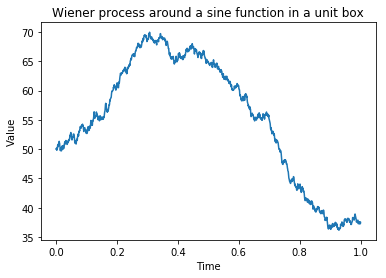

In [314]:
N=1500
y=gen_dx_recursive(mu_real=0.001,sig_real=0.01,dt=1,N=N)
plt.title('Wiener process around a sine function in a unit box')
#plt.ylim((-0.1,1.1))
x_axis=np.divide(np.arange(1,N+1),N)
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(x_axis,y)
plt.savefig('Wiener_sine_box.pdf')

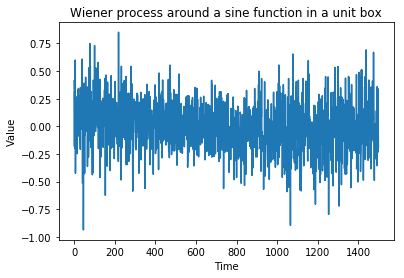

In [315]:
N=1500
y=gen_dx_recursive(mu_real=0.001,sig_real=0.01,dt=1,N=N)
plt.title('Wiener process around a sine function in a unit box')
#plt.ylim((-0.1,1.1))
x_axis=np.divide(np.arange(1,N+1),N)
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(np.diff(y))

In [316]:
#convergence for increasing number of paths and samples

N_test=np.array([10,100,1000]) #,100,500,1000,10000,50000

fix_dt=1
param_real_test=np.array([0.3,0.1])
param_initial_test= np.array([0.5,0.03])

num_paths_test=np.array([1,10,20]) #,1000,10000


result_fixeddt_avg=np.zeros((len(num_paths_test),len(N_test),2))
err_fixeddt_avg=np.zeros((len(num_paths_test),len(N_test),2))

for i in range(0,len(num_paths_test)):
    result_fixeddt,_=convergence_in_L(N_test,fix_dt,param_real_test,param_initial_test,num_paths_test[i] )
    #obtain averaging estimator
    result_fixeddt_avg[i]=np.average(result_fixeddt, axis=0)
    #error estimates
    err_fixeddt_avg[i,:,0] = np.divide ( abs(result_fixeddt_avg[i,:,0] - param_real_test[0]), param_real_test[0] )
    err_fixeddt_avg[i,:,1]=np.divide ( abs(result_fixeddt_avg[i,:,1] - param_real_test[1]), param_real_test[1] )


In [317]:
result_fixeddt_avg

array([[[-1.13191986e-02,  4.37087093e-03],
        [ 2.03165762e-01,  5.16516152e-01],
        [ 6.83288929e-04,  2.26645490e-01]],

       [[-2.83784986e-02,  5.07452156e-03],
        [-4.34481916e-01,  4.28329747e-01],
        [-1.17390320e-02,  6.84719882e-01]],

       [[-3.13808723e-02,  4.86080664e-03],
        [-2.31247676e-01,  4.76640091e-01],
        [-3.46776809e-02,  5.72686866e-01]]])

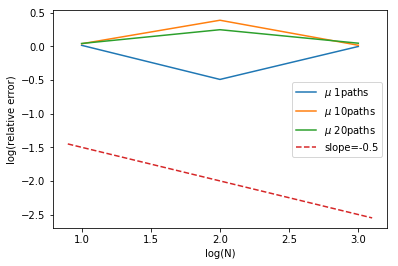

In [318]:
plt.title('')
plt.xlabel('log(N)')
plt.ylabel('log(relative error)')
for i in range(0, len(num_paths_test)):
    mu_label='$\mu$ '+ str(num_paths_test[i]) +'paths'
    sig_label='$\sigma$ '+ str(num_paths_test[i]) +'paths'
    plt.plot(np.log10(N_test),  np.log10(err_fixeddt_avg[i,:,0]), label=mu_label)
    #plt.plot(np.log10(N_test),  np.log10(err_fixeddt_avg[i,:,1]) , label=sig_label)
abline(-0.5,-1)
plt.legend()
plt.savefig('wiener_sin_mu.pdf')

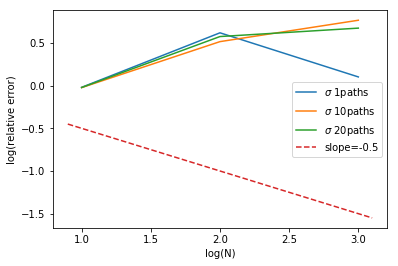

In [319]:
plt.title('')
plt.xlabel('log(N)')
plt.ylabel('log(relative error)')
for i in range(0, len(num_paths_test)):
    mu_label='$\mu$ '+ str(num_paths_test[i]) +'paths'
    sig_label='$\sigma$ '+ str(num_paths_test[i]) +'paths'
    #plt.plot(np.log10(N_test),  np.log10(err_fixeddt_avg[i,:,0]), label=mu_label)
    plt.plot(np.log10(N_test),  np.log10(err_fixeddt_avg[i,:,1]) , label=sig_label)
abline(-0.5,0)
plt.legend()
plt.savefig('wiener_sin_sig.pdf')

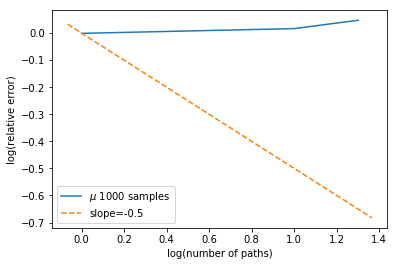

In [320]:
plt.title('')
plt.xlabel('log(number of paths)')
plt.ylabel('log(relative error)')
#for i in range(0, len(num_paths_test)):
mu_label='$\mu$ ' + str(N_test[-1]) +' samples'
sig_label='$\sigma$ '+ str(N_test[-1]) +' samples'
plt.plot(np.log10(num_paths_test),  np.log10(err_fixeddt_avg[:,-1,0]), label=mu_label)
#plt.plot(np.log10(N_test),  np.log10(err_fixeddt_avg[i,:,1]) , label=sig_label)
abline(-0.5,0)
plt.legend()
plt.savefig('wiener_sin_mu_fixedN.pdf')

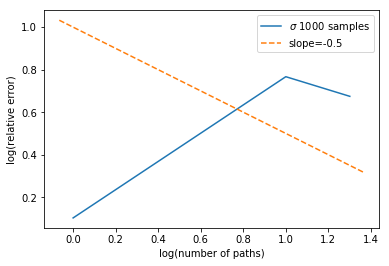

In [321]:
plt.title('')
plt.xlabel('log(number of paths)')
plt.ylabel('log(relative error)')
#for i in range(0, len(num_paths_test)):
#mu_label='$\mu$ ' + str(N_test[-1]) +' samples'
sig_label='$\sigma$ '+ str(N_test[-1]) +' samples'
plt.plot(np.log10(num_paths_test),  np.log10(err_fixeddt_avg[:,-1,1]), label=sig_label)
#plt.plot(np.log10(N_test),  np.log10(err_fixeddt_avg[i,:,1]) , label=sig_label)
abline(-0.5,1)
plt.legend()
plt.savefig('wiener_sin_sig_fixedN.pdf')

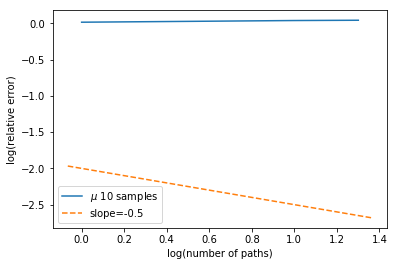

In [322]:
plt.title('')
plt.xlabel('log(number of paths)')
plt.ylabel('log(relative error)')
#for i in range(0, len(num_paths_test)):
mu_label='$\mu$ ' + str(N_test[0]) +' samples'
sig_label='$\sigma$ '+ str(N_test[0]) +' samples'
plt.plot(np.log10(num_paths_test),  np.log10(err_fixeddt_avg[:,0,0]), label=mu_label)
#plt.plot(np.log10(N_test),  np.log10(err_fixeddt_avg[i,:,1]) , label=sig_label)
abline(-0.5,-2)
plt.legend()
plt.savefig('wiener_sin_mu_fixedN_0.pdf')

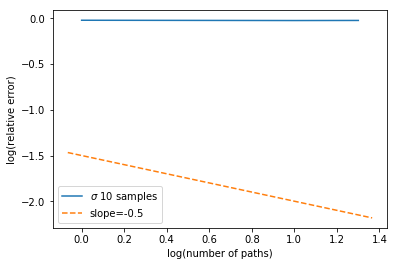

In [323]:
plt.title('')
plt.xlabel('log(number of paths)')
plt.ylabel('log(relative error)')
#for i in range(0, len(num_paths_test)):
#mu_label='$\mu$ ' + str(N_test[-1]) +' samples'
sig_label='$\sigma$ '+ str(N_test[0]) +' samples'
plt.plot(np.log10(num_paths_test),  np.log10(err_fixeddt_avg[:,0,1]), label=sig_label)
#plt.plot(np.log10(N_test),  np.log10(err_fixeddt_avg[i,:,1]) , label=sig_label)
abline(-0.5,-1.5)
plt.legend()
plt.savefig('wiener_sin_sig_fixedN_0.pdf')